<h2>Project 7: CART</h2>


<!--announcements-->
<blockquote>
    <center>
    <img src="forest.jpg" width="400px" />
    </center>
      <p><cite><center>Boosting took a long time to be truly understood.<br>
      ... cynics say we didn't see the forest for all the trees ...<br>
      </center></cite></p>
</blockquote>

<!--announcements-->






<h3>Introduction</h3>
<p>In this assignment you will implement a decision tree algorithm and then use it for bagging and boosting. We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value). Nodes have six fields: 

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> so long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>
</ol>
</p>


        

In [1]:
#<GRADED>
class TreeNode(object):
    """Tree class.
    
    (You don't need to add any methods or fields here but feel
    free to if you like. Our tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction
#</GRADED>

<h3>Implementing CART</h3>
Before we get started let us add a few packages that you might need. We will also load a data set <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
#<GRADED>
import numpy as np
from pylab import *
from numpy.matlib import repmat
#</GRADED>
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
%matplotlib notebook

# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

xTrIon.shape, yTrIon.shape, xTeIon.shape, yTeIon.shape

((281, 34), (281,), (70, 34), (70,))

In [3]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral=spiraldata(150)

<h3> Efficiently implementing regression trees </h3>
<p>First, implement the function <code>sqsplit</code> which takes as input a (weighted) data set with labels and computes the best feature and cut-value of an optimal split based on minimum squared error. The third input is a weight vector which assigns a positive weight to each training sample. The loss you should minimize is the averaged weighted squared-loss:
$$
	{\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2.\label{q2:loss}
$$
<br>
</p>

You are building a regression tree, and right now you need to choose a split for the given dataset $S=\{(\vec x_1,y_1),\dots,(\vec x_n,y_n)\}$ (where we have continuous labels $y_i\in{\cal R}$).
Suppose you split on some feature $j$ with value $c$ and partition the dataset in to two sets of indices, $L$--the set of indices on the left (i.e., $i \in L \Rightarrow [x_{i}]_{j} < c$)--and $R$--the set of indices on the right (i.e., $i \in R \Rightarrow [x_{i}]_{j} > c$). Suppose you assign every data point on the left the prediction $T_{L}$ and every data point on the right the prediction $T_{R}$. Finally, suppose that each data point $x_{i}$ has an associated weight $w_{i}$, and that the weights are normalized (i.e., $\sum_{i} w_{i} = 1$). 


<p> First, we show that setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets (i.e., $T_{L} = \frac{1}{W_{L}}\sum_{i\in L}w_{i}y_{i}$ and $T_{R} = \frac{1}{W_{R}}\sum_{i\in R}w_{i}y_{i}$) minimizes the loss $\cal L$, where $W_{L}=\sum_{i \in L}w_{i}$ and $W_{R}=\sum_{i \in R} w_{i}$ are the total weight of the left and right side respectively.

<p> We take the derivative of the loss with respect to $T_{L}$ to obtain $$\frac{d}{dT_{L}} {\cal L}(S) = -2\sum_{i \in L}w_{i}(y_i - T_L)=-2\sum_{i\in L}w_iy_i + 2T_{L}\sum_{i}w_{i}$$ Setting this equal to zero and solving, we get $$2T_{L}w_{L}=2\sum_{i \in L}w_{i}y_{i}$$ and therefore $$T_{L} = \frac{1}{W_{L}}\sum_{i \in L}w_{i}y_{i}$$ A symmetric argument holds for $T_{R}$.</p>

<p> Now, imagine you are considering splitting on some feature $j$, and suppose you have already sorted the training points in the order of this feature value, so that $[x_{1}]_{j} < [x_{2}]_{j} < \cdots < [x_{n}]_{j}$. You'd like to choose a split from among $c_{1} \leq c_{2} \leq \cdots \leq c_{n-1}$, where $c_{i}=\frac{[x_{i}]_{j}+[x_{i+1}]_{j}}{2}$. One way to do this would be to, for each possible split $c_{k}$, decide whether each $x_{i}$ should be partitioned left or right, and compute $\cal L$. At the end, take the split with the lowest loss. The number of data points $n$ and there are $O(n)$ splits to consider, and the proposed algorithm would require $O(n)$ per split to evaluate $\cal L$, for a total of $O(n^2)$ time.

<p> Now, suppose some split $c_{k}$ results in the data being partitioned in to $L^{(k)}$ and $R^{(k)}$. Suppose you are given the following quantities precomputed: $W_{L^{(k)}}$, $P_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}$, and $Q_{L^{(k)}} = \sum_{i \in L} w_{i}y_{i}^{2}$. Similarly, you are given $W_{R^{(k)}}$, $P_{R^{(k)}}$ and $Q_{R^{(k)}}$ Equipped with these precomputed quantities, we can compute $\cal L$ in constant time:

<p>Expand the left side of the loss to $$\sum_{i \in L}w_{i}y_{i}^{2} - 2\sum_{i \in L}w_{i}y_{i}T_{L} + \sum_{i \in L}w_{i}T_{L}^{2}$$. The first term is exactly $Q_{L^{(k)}}$. The second term can be written as $-2P_{L^{(k)}}\frac{P_{L^{(k)}}}{W_{L^{(k)}}}=-2\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The last term can be written as $w_{L^{(k)}}\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}^{2}}=\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. The second term plus the third term is therefore simply $-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$. Therefore the whole expression can be evaluated as: $$Q_{L^{(k)}}-\frac{P_{L^{(k)}}^{2}}{w_{L^{(k)}}}$$ Similarly, the right term is: $$Q_{R^{(k)}}-\frac{P_{R^{(k)}}^{2}}{w_{R^{(k)}}}$$</p>

<p> <b> Efficent Update Rule: </b> If all feature values are distinct, only one data point moves from $R$ to $L$ when moving from split $k$ to split $k+1$. Therefore, we simply update the values accordingly. For example, we subtract $w_{k}$ from $W_{R^{(k)}}$ and add it to $W_{L^{(k)}}$. We subtract $w_{k}y_{k}$ from $P_{R^{(k)}}$ and add it to $P_{L^{(k)}}$. We subtract $w_{k}y_{k}^{2}$ from $Q_{R^{(k)}}$ and add it to $Q_{L^{(k)}}$. Crucially, all of these updates take only constant time. </p>

In [4]:
#<GRADED>

def find_cut(xTr, yTr, weights, index):
    """
    Finds the best cut in feature index
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
        index: index of features in which the best cut to find
    
    Output:
        cut:      cut-value of the best cut in feature index
        bestloss: loss of the best cut in feature index
        
    """
    
    N, D = xTr.shape
    eps= 1e-10
    # indices of sorted xTr[:,index] in increaseing order
    sort_idx = np.argsort(xTr[:,index])
    x_chosen = xTr[:, index]
    # initiliaze
    W_L, P_L, Q_L = 0,0,0
    
    W_R = 1
    P_R = np.inner(weights, yTr) 
    Q_R = np.inner(weights, yTr**2)
    bestloss = Q_R - P_R**2/W_R
    cut = x_chosen[0] - 1
    
    for i, idx in enumerate(sort_idx):
        # Update according to formula above
        W_L += weights[idx]
        W_R -= weights[idx]
        
        P_L += weights[idx]*yTr[idx]
        P_R -= weights[idx]*yTr[idx]
        
        Q_L += weights[idx]*yTr[idx]**2
        Q_R -= weights[idx]*yTr[idx]**2
        
        # if x is the same as next x, go to the next cut
        if (i+1) != N:
            if xTr[idx, index] == xTr[sort_idx[i+1], index]:
                continue
        
        loss = Q_L + Q_R - P_R*P_R/(W_R+eps) - P_L*P_L / (W_L+eps)
        
        if loss < bestloss:
            bestloss = loss
            # if i is last index, then cut is 1 + xTr[last_index, index]
            if (i+1) != N:
                cut = (x_chosen[idx] + x_chosen[sort_idx[i+1]])/2
            else:
                cut = xTr[idx, index] + 1
        
    return cut, bestloss


def sqsplit(xTr,yTr,weights=[]):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if len(weights) == 0: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights / sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    # TODO:
    #raise Exception("Not Implemented")
    for j in range(D):
        #find the best cut within feature j
        cut_feature, loss = find_cut(xTr, yTr, weights, j)
        
        # if its better, update it
        if loss < bestloss:
            bestloss = loss
            cut = cut_feature
            feature = j

    return feature, cut, bestloss
    
#</GRADED>


In [5]:
t0 = time.time()
fid,cut,loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()
print('elapsed time:',t1-t0,'seconds')
print("It should split on feature 2 on value: 0.29920161791103117")
print("Split on feature",fid,"on value:",cut)

elapsed time: 0.29797840118408203 seconds
It should split on feature 2 on value: 0.29920161791103117
Split on feature 2 on value: 0.30440689508953356


<b>Cart tree:</b><p>Implement the function <code>cart</code> which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, test data, a maximum depth, and the weigh of each training example. Maximum depth and weight are optional arguments. If they are not provided you should make maximum depth infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>


In [22]:
#<GRADED>
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights

    # TODO:
    #raise Exception("Not Implemented")
    
    # DFS algorithm
    # Create the node
    Node = TreeNode(left=None, right=None, parent=None, 
             cutoff_id=None, cutoff_val=None, prediction=None)

    # stop at pure node, otherwise continue the search or construction of tree
    # base case
    if np.all(yTr == yTr[0]):
        Node.prediction = yTr[0]
        return Node
    
    # Prediction = most frequent (mod) of the array yTr
    cst = - (np.min(yTr) - 1).astype(np.int32)
    y_arr = (yTr + cst).astype(np.int32)
    #Node.prediction = np.bincount(y_arr).argmax() - cst
    Node.prediction = np.dot(yTr, w)
    
    if depth <= 1:
        return Node

    # Determine the optimal cut
    Node.cutoff_id, Node.cutoff_val, _ = sqsplit(xTr, yTr, w)


    # indices of elements in left and right nodes
    idx_L = xTr[:, Node.cutoff_id] < Node.cutoff_val
    idx_R = xTr[:, Node.cutoff_id] >= Node.cutoff_val

    # Create the Left and Right data for children nodes
    xTr_L = xTr[idx_L]
    yTr_L = yTr[idx_L]
    xTr_R = xTr[idx_R]
    yTr_R = yTr[idx_R]

    depth_L, depth_R = depth-1, depth-1
    weights_L, weights_R = w[idx_L], w[idx_R]

    # left child
    left_child = cart(xTr_L, yTr_L, depth_L, weights_L)

    # right child
    right_child = cart(xTr_R, yTr_R, depth_R, weights_R)

    # Connect parent and childs
    Node.left, Node.right = left_child, right_child
    left_child.parent, right_child.parent = Node, Node
        
    return Node
    
    
#</GRADED>

In [23]:
#<GRADED>
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights

    # TODO:
    #raise Exception("Not Implemented")
    if len(set(yTr))==1 or (xTr == xTr[0]).all() or depth == 1:
        tree = TreeNode(None, None, None, None, None, np.dot(w,yTr)/np.sum(w))
        return tree
    

    feature, cut, bestloss = sqsplit(xTr,yTr,w)   
    tree = TreeNode(None, None, None, feature, cut, np.dot(w,yTr)/np.sum(w))    # set the parameter of the tree
        
    xTrLeft, xTrRight = xTr[xTr[:,feature] <= cut,:], xTr[xTr[:,feature] > cut,:]
    yTrLeft, yTrRight = yTr[xTr[:,feature] <= cut], yTr[xTr[:,feature] > cut]
    wLeft, wRight = w[xTr[:,feature] <= cut], w[xTr[:,feature] > cut]       # split data into left and right set
        
    tree.left = cart(xTrLeft,yTrLeft,depth-1,wLeft)
    tree.right = cart(xTrRight,yTrRight,depth-1,wRight)
    tree.left.parent = tree
    tree.right.parent = tree                     # recursion on splitting, building the tree
        
    return tree    
    
    
#</GRADED>

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [24]:
from copy import deepcopy
#<GRADED>

def DFS_pred(root, x_data):
    if root.left is None or root.right is None:
        return root.prediction
    cut = root.cutoff_val
    feat_idx = root.cutoff_id
    if (x_data[feat_idx] < cut):
        Node = root.left
    else:
        Node = root.right
    return DFS_pred(Node, x_data)


def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    assert root is not None
    n = xTe.shape[0]
    pred = np.zeros(n)
    
    # TODO:
    #raise Exception("Not Implemented")
    for i in range(n):
        pred[i] = DFS_pred(root, xTe[i])

    return pred
#</GRADED>

In [25]:
t0 = time.time()
print(xTrIon.shape)
root = cart(xTrIon, yTrIon, 99)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f" % te_err)

(281, 34)
elapsed time: 1.20 seconds
Training RMSE : 0.00
Testing  RMSE : 0.74


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

<IPython.core.display.Javascript object>


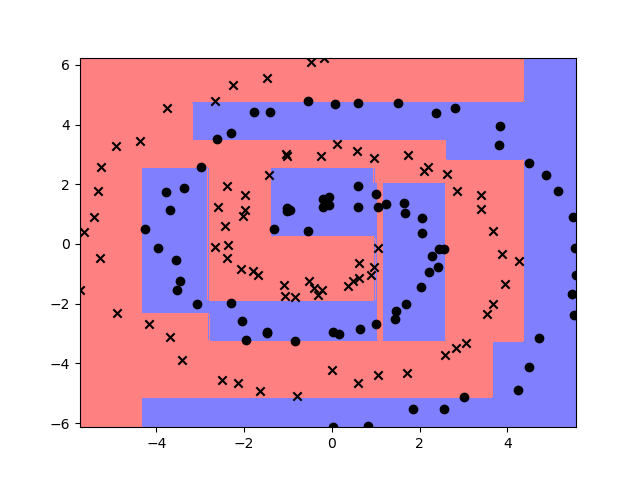

Training error: 0.0000
Testing error:  0.0800


In [26]:
def visclassifier(fun,xTr,yTr,w=[],b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(yTr)

    plt.figure()

    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    testpreds = fun(xTe)
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )

    if len(w) != 0:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    plt.show()
    
tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


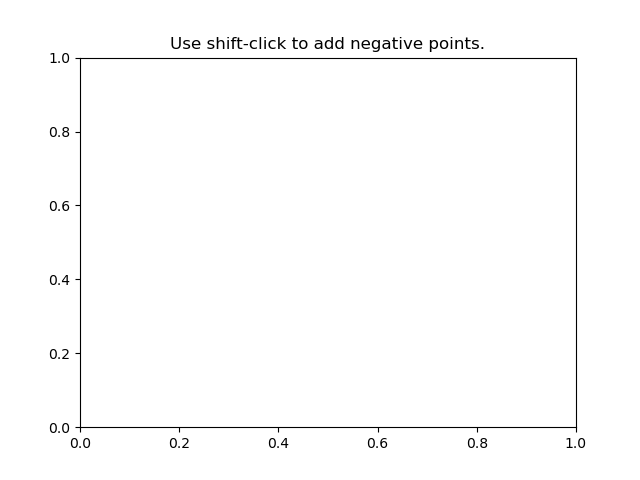

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [27]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTraining= np.array([[5,6]])
labels = [1]
%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Use shift-click to add negative points.')

<h2>Random Forests</h2>
<p>CART trees are known to be high variance classifiers
(if trained to full depth).
An effective way to prevent overfitting is to use <b>Bagging</b>.
Implement the function <code>forest</code>,
which builds a forest of regression trees.
Each tree should be built using training data
drawn by randomly sampling $n$ examples
from the training data with replacement.
Do not randomly sample features.
The function should output a list of trees.</p>

In [28]:
#<GRADED>
def forest(xTr, yTr, m, maxdepth=np.inf):
    """Creates a random forest.
    
    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        
    Output:
        trees: list of TreeNode decision trees of length m
    """
    
    n, d = xTr.shape
    trees = []
    
    # TODO:
    #raise Exception("Not Implemented")
    for i in range(m):
        samples = np.random.choice(n,n)
        x_sample = xTr[samples,:]
        y_sample = yTr[samples]
        tree = cart(x_sample, y_sample, maxdepth)
        trees.append(tree)
    return trees
#</GRADED>

<p>Now implement the function <code>evalforest</code>, which should take as input a set of $m$ trees, a set of $n$ test inputs, and an $m$ dimensional weight vector. Each tree should be weighted by the corresponding weight. (For random forests you can define the weights to be $\frac{1}{m}$ for all trees.</p>

In [29]:
#<GRADED>
def evalforest(trees, X, alphas=None):
    """Evaluates X using trees.
    
    Input:
        trees:  list of TreeNode decision trees of length m
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector
        
    Output:
        pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    if alphas is None:
        alphas = np.ones(m) / len(trees)
            
    pred = np.zeros(n)
    
    # TODO:
    #raise Exception("Not Implemented") 
    for idx,tree in enumerate(trees):
        pred += evaltree(tree, X)*alphas[idx]

    return pred
#</GRADED>

<p>The following script visualizes the decision boundary of a random forest ensemble.</p>

<IPython.core.display.Javascript object>


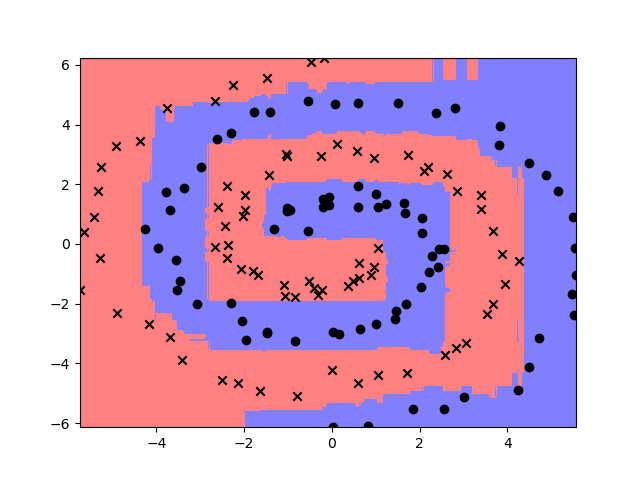

Training error: 0.0000
Testing error:  0.0800


In [30]:
trees=forest(xTrSpiral,yTrSpiral,30) # compute tree on training data 
visclassifier(lambda X:evalforest(trees,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

<p>The following script evaluates the test and training error of a random forest ensemble as we vary the number of trees.</p>

[0]training err = 0.0747	testing err = 0.2000
[1]training err = 0.0641	testing err = 0.1714
[2]training err = 0.0285	testing err = 0.1286
[3]training err = 0.0178	testing err = 0.1429
[4]training err = 0.0071	testing err = 0.1143
[5]training err = 0.0178	testing err = 0.1143
[6]training err = 0.0071	testing err = 0.1143
[7]training err = 0.0107	testing err = 0.1143
[8]training err = 0.0107	testing err = 0.1286
[9]training err = 0.0107	testing err = 0.1143
[10]training err = 0.0071	testing err = 0.1000
[11]training err = 0.0071	testing err = 0.1000
[12]training err = 0.0036	testing err = 0.1000
[13]training err = 0.0036	testing err = 0.1000
[14]training err = 0.0000	testing err = 0.1000
[15]training err = 0.0000	testing err = 0.1143
[16]training err = 0.0000	testing err = 0.1000
[17]training err = 0.0000	testing err = 0.1000
[18]training err = 0.0000	testing err = 0.1000
[19]training err = 0.0000	testing err = 0.0857


<IPython.core.display.Javascript object>


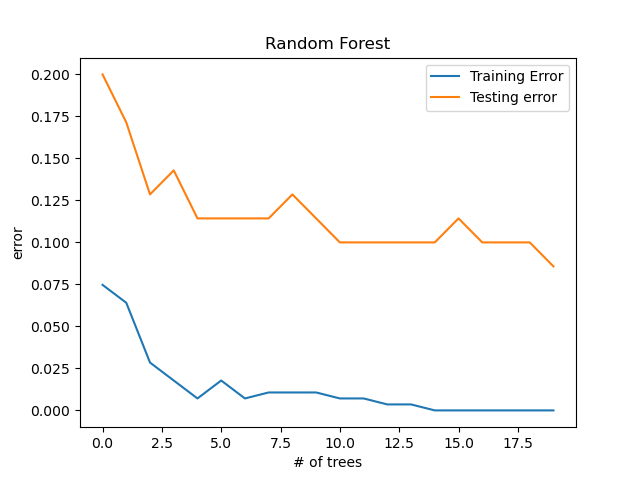

In [31]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
alltrees=forest(xTrIon,yTrIon,M)
for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees,xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

<IPython.core.display.Javascript object>


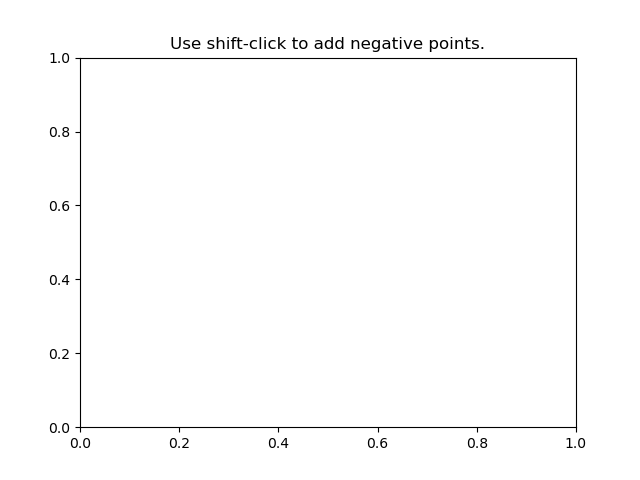

Note: there is strong delay between points


Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [32]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
        
    w = np.array(w).flatten()
    
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees=forest(xTrain,yTrain,M)
    fun = lambda X:evalforest(trees,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=20

fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: there is strong delay between points')
plt.title('Use shift-click to add negative points.')

<h2>Boosting</h2>

<p>Another option to improve your decision trees is to build trees of small depth (e.g. only depth=3 or depth=4). These do not have high variance, but instead suffer from <b>high bias</b>. You can reduce the bias of a classifier with boosting. Implement the function <code>boosttree</code>, which applies Adaboost on your <code>cart</code> functions. You should be able to use the function <code>evalforest</code> to evaluate your boosted ensemble (provdided you pass on the weights correctly.)</p>

In [33]:
#<GRADED>
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.
    
    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree
        
    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector
        
    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1 
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    # TODO:
    #raise Exception("Not Implemented") 
    for i in range(maxiter):
        # instead of choosing argmin, create it
        tree = cart(x, y, maxdepth, weights)
        preds = np.sign(evaltree(tree, x))
        
        # error
        eps = np.sum(weights[preds != y])
        
        if eps < 0.5:
            alpha = 0.5*np.log((1-eps)/eps)
            alphas.append(alpha)
            forest.append(tree)
            weights = weights*np.exp(-alpha*preds*y) / np.sqrt(4*eps*(1-eps))
        else:
            break
    
    return forest, alphas
#</GRADED>

<p>The following script evaluates the test and training error of a boosted forest as we increase the number of trees.</p>

[0]training err = 0.0676	testing err = 0.1429
[1]training err = 0.0605	testing err = 0.1857
[2]training err = 0.0107	testing err = 0.1857
[3]training err = 0.0000	testing err = 0.1714
[4]training err = 0.0000	testing err = 0.1571
[5]training err = 0.0000	testing err = 0.1286
[6]training err = 0.0000	testing err = 0.1571
[7]training err = 0.0000	testing err = 0.1429
[8]training err = 0.0000	testing err = 0.1571
[9]training err = 0.0000	testing err = 0.1429
[10]training err = 0.0000	testing err = 0.0857
[11]training err = 0.0000	testing err = 0.0857
[12]training err = 0.0000	testing err = 0.1000
[13]training err = 0.0000	testing err = 0.0714
[14]training err = 0.0000	testing err = 0.0857
[15]training err = 0.0000	testing err = 0.0857
[16]training err = 0.0000	testing err = 0.0714
[17]training err = 0.0000	testing err = 0.1000
[18]training err = 0.0000	testing err = 0.1000
[19]training err = 0.0000	testing err = 0.1143


<IPython.core.display.Javascript object>


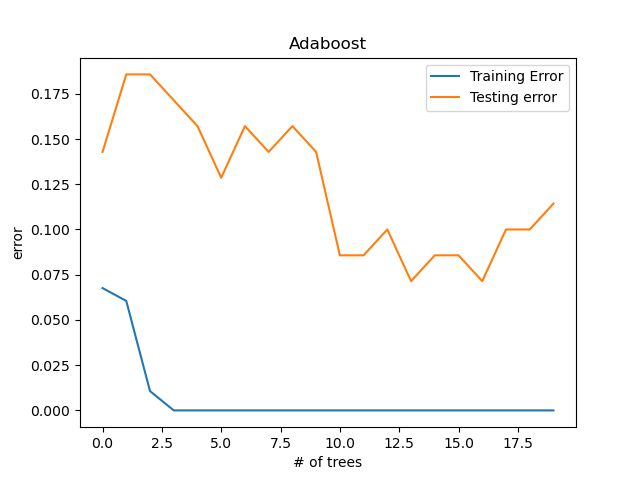

In [34]:
M=20 # max number of trees
alltrees,allalphas=boosttree(xTrIon,yTrIon,maxdepth=4,maxiter=M)

err_trB=[]
err_teB=[]
for i in range(M):
    trees=alltrees[:i+1]
    alphas=allalphas[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon,alphas)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees,xTeIon,alphas)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M),err_trB,label="Training Error")
line_te, = plt.plot(range(M),err_teB,label="Testing error")
plt.title("Adaboost")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

<IPython.core.display.Javascript object>


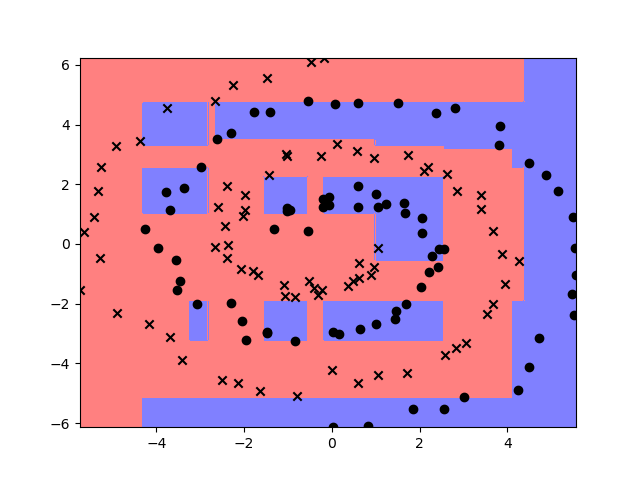

elapsed time: 1.20 seconds
Training error: 0.1000
Testing error:  0.1800


In [35]:
trees,alphas=boosttree(xTrSpiral,yTrSpiral,maxdepth=3,maxiter=20)
visclassifier(lambda X:evalforest(trees,X,alphas),xTrSpiral,yTrSpiral)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


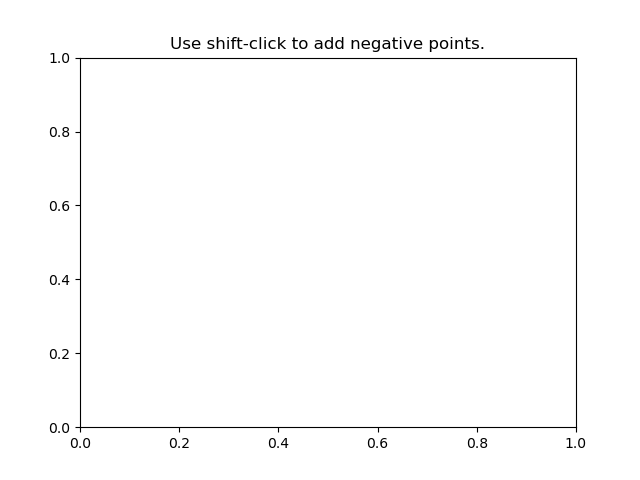

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [36]:
xTrain= np.array([[5,6],[2,5]])
yTrain = np.array([-1,1])
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)


def onclick_boost(event):
    """
    Visualize boosting, including new point
    """
    global xTrain,yTrain
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)
            
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0,1,res)
    yrange = np.linspace(0,1,res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # get forest
    forest,alphas=boosttree(xTrain,yTrain,maxdepth=3,maxiter=5)
    if len(forest) > 0:
        fun = lambda X: evalforest(forest,X,alphas)
        # test all of these points on the grid
        testpreds = fun(xTe)

        # reshape it back together to make our grid
        Z = testpreds.reshape(res, res)
        Z[0,0] = 1 # optional: scale the colors correctly

        plt.cla()    
        plt.xlim((0,1))
        plt.ylim((0,1))
        # fill in the contours for these predictions
        plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick_boost)
plt.title('Use shift-click to add negative points.')

**Competition**: we ask you to improve the speed of evaltree and cart while keeping both functions accurate.
    
You will receive points if your implemention is faster than our naive implementation.

In [21]:
#<GRADED>
def evaltreecomp(root,xTe,idx=[]):
    """Evaluates xTe using decision tree root. Same as evaltree but designed to be as efficient as possible.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
        idx:  choosen indices, optional argument that might be helpful with implementation strategy
    Output:
        pred: n-dimensional vector of predictions
    """
    assert root is not None
    n = xTe.shape[0]
    pred = np.zeros(n)
    
    # TODO:
    #raise Exception("Not Implemented")
    
    return evaltree(root,xTe)

def cartcomp(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree. Same as cart but designed to be as efficient as possible.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    return cart(xTr,yTr,depth,weights)
    # TODO:
    #raise Exception("Not Implemented")
#</GRADED>